In [1]:
# !pip install strawberryfields
!pip install pennylane
!python -m pip install pennylane-sf
# !pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

env: OMP_NUM_THREADS=1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## hyperparams

In [4]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


## MNIST dataset

In [25]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]

    # a = tf.constant([0.1, 1.0], dtype=tf.float32)

    return train_x, train_y, test_x, test_y

    # return tf.constants(train_x, requires_grad=False), torch.tensor(train_y, requires_grad=False), torch.tensor(test_x, requires_grad=False), torch.tensor(test_y, requires_grad=False)

In [26]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1

    if samples_number > 4:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]))
    else:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            axs[i % 4].imshow(samples[index].reshape([8, 8]))
            
    plt.show()

In [27]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

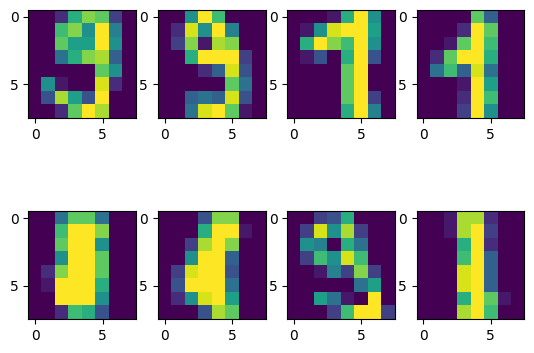

In [28]:
draw_samples(test_x, 8)

In [29]:
shots = 100
dev = qml.device("strawberryfields.tf", wires=4, cutoff_dim=10)  #, shots=shots

In [102]:
params_num = 20

def make_matrixes(image, shape):

    # print(image.shape)
    # shape, input = shaper(image)

    matrixes = []
    input = image

    for subimage in range(image.shape[0]):
        submatrix = []
        for j in range(0, shape, 2):
            for k in range(0, shape, 2):
                # Process a squared 2x2 region of the image with a quantum circuit
                submatrix.append(
                    [
                        input[subimage, j, k],
                        input[subimage, j, k + 1],
                        input[subimage, j + 1, k],
                        input[subimage, j + 1, k + 1]
                    ]
                )
        matrixes.append(tf.convert_to_tensor(submatrix, dtype=tf.float32))

    return matrixes

In [128]:
@qml.qnode(dev, interface="tf")
def conv_2x2_layer(params, phi, delta):
    print(phi.shape)

    for j in range(4):
        qml.Squeezing(1.5, phi[j], wires=j)
    
    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])
    qml.Beamsplitter(np.pi / 4, 0, wires=[2, 3])

    for j in range(4):
        qml.Rotation(params[j + delta], wires=j)

    qml.Beamsplitter(np.pi / 4, 0, wires = [1, 2])
    qml.Rotation(params[4 + delta], wires=1)
    qml.Rotation(params[5 + delta], wires=2)

    return qml.expval(qml.NumberOperator(1))

In [129]:
@qml.qnode(dev, interface="tf")
def fc_layer(params, phi, delta, fock_prob):
    for j in range(4):
        qml.Squeezing(1.5, phi[j], wires = j)
    
    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])
    qml.Beamsplitter(np.pi / 4, 0, wires=[2, 3])

    # for j in range(4):
    qml.Rotation(params[j + delta], wires=j)

    qml.Beamsplitter(np.pi / 4, 0, wires = [1, 2])
    qml.Rotation(params[4 + delta], wires=1)
    qml.Rotation(params[5 + delta], wires=2)
    qml.Displacement(params[6 + delta], 0.0, wires=0)
    qml.Displacement(params[7 + delta], 0.0, wires=1)

    return qml.expval(op=qml.FockStateProjector(fock_prob, wires=[0,1]))
    # return qml.expval(qml.NumberOperator(1))

In [130]:
def circuit(params, image):

    print(image.shape)
    
    input = tf.reshape(image, (image.shape[0], 8, 8))
    matrixes = tf.convert_to_tensor(make_matrixes(input, 8))
    print(matrixes.shape)

    conv_output = [tf.convert_to_tensor(conv_2x2_layer(params, phi, delta=0), dtype=tf.float32) for phi in matrixes]
    # conv_output = conv_2x2_layer(params, phi, delta=0)
    
    conv_output = tf.reshape(conv_output, (4, 4))
    matrixes = make_matrixes(conv_output, 4)

    conv_output = tf.conver_to_tensor([conv_2x2_layer(params, phi, delta=6) for phi in matrixes])

    fock_prob_02 = np.array([0,2], requires_grad=False)
    fock_prob_20 = np.array([2,0], requires_grad=False)
    p0 = fc_layer(params=params, phi=conv_output, delta=12, fock_prob=fock_prob_02)
    p1 = fc_layer(params=params, phi=conv_output, delta=12, fock_prob=fock_prob_20)

    return [p0 / (p1 + p0 + 1e-8), p1 / (p1 + p0 + 1e-8)] 

In [131]:
def accuracy(labels, predictions):
    acc = 0
    pred = np.round(predictions)
    for l, p in zip(labels, np.abs(pred)):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

In [132]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

steps = 40
var = tf.Variable([0.5]*params_num)

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# train_x = 

for step in range(steps):
    print(f"Iter: {step+1:5d} | params: {var}")

    with tf.GradientTape() as tape:
        predictions = circuit(var, train_x)
        train_loss = tf.keras.losses.binary_crossentropy(train_y, predictions)

    gradients = tape.gradient(train_loss, [var])
    opt.apply_gradients(zip(gradients, [var]))

    train_accuracy = accuracy(train_y, tf.round(predictions))

    print('collecting_data')
    predictions = tf.convert_to_tensor([circuit(var, x) for x in test_x])
    val_loss = tf.keras.losses.binary_crossentropy(test_y, predictions)
    val_accuracy = accuracy(test_y, tf.round(predictions))

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

Iter:     1 | params: <tf.Variable 'Variable:0' shape=(20,) dtype=float32, numpy=
array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)>
(326, 64)
(326, 16, 4)
(16, 4)


TypingError: ignored